In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Set dataset root folder
data_root = "/content/drive/My Drive/brain_tumor_classification/brain_tumor/data"
images_path = os.path.join(data_root, 'images')
labels_path = os.path.join(data_root, 'labels')


In [ ]:
import os
import pandas as pd
from pathlib import Path

# Set dataset root folder
data_root = "/content/drive/My Drive/brain_tumor_classification/brain_tumor/data"
images_path = os.path.join(data_root, 'images')
labels_path = os.path.join(data_root, 'labels')
augmented_path = os.path.join(data_root, 'augmented')
testing_path = os.path.join(data_root, 'testing_data')

# Step 1: Build a set of test image names (no extensions)
test_image_names = set()
for root, _, files in os.walk(testing_path):
    for f in files:
        if f.endswith(('.png', '.jpg', '.jpeg')):
            test_image_names.add(f)

# Helper: get label path from top-level 'labels/' folder
def get_label_path(image_file):
    return os.path.join(labels_path, Path(image_file).stem + ".txt")

# Step 2: Collect original data from 'images/' and 'labels/'
original_images = [os.path.join(images_path, f)
                   for f in os.listdir(images_path)
                   if f.endswith(('.png', '.jpg', '.jpeg')) and f not in test_image_names]

original_data = []
for img in original_images:
    label_path = get_label_path(img)
    if os.path.exists(label_path):
        original_data.append((Path(img).stem, img, label_path))

# Step 3: Collect augmented data (image + label in same folder)
augmented_data = []
for root, _, files in os.walk(augmented_path):
    for f in files:
        if f.endswith(('.png', '.jpg', '.jpeg')) and f not in test_image_names:
            img_path = os.path.join(root, f)
            label_filename = Path(f).stem + ".txt"
            label_path = os.path.join(root, label_filename)

            if os.path.exists(label_path):
                augmented_data.append((Path(img_path).stem, img_path, label_path))

# Step 4: Combine and export
combined_data = original_data + augmented_data
df = pd.DataFrame(combined_data, columns=["id", "image_path", "label_path"])

csv_output_path = os.path.join(data_root, "mapped_data.csv")
df.to_csv(csv_output_path, index=False)

print(f"✅ Mapped CSV created at: {csv_output_path}")
df.head()
print(f"🔢 Total rows in CSV: {len(df)}")



✅ Mapped CSV created at: /content/drive/My Drive/brain_tumor_classification/brain_tumor/data/mapped_data.csv
🔢 Total rows in CSV: 4212


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class TumorResNet(nn.Module):
    def __init__(self):
        super(TumorResNet, self).__init__()

        # Load pretrained ResNet18 (you can upgrade to ResNet34/50 later)
        base_model = models.resnet18(pretrained=True)

        # Adjust for grayscale input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = base_model.conv1.weight.data.mean(dim=1, keepdim=True)

        # Extract the rest of the ResNet (minus last layer)
        self.resnet_body = nn.Sequential(
            self.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool,
            base_model.layer1,
            base_model.layer2,
            base_model.layer3,
            base_model.layer4,
            base_model.avgpool
        )

        self.flatten = nn.Flatten()

        # Feature size after ResNet's avgpool for ResNet18 = 512
        feature_dim = 512

        # Output heads
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 1),
            nn.Sigmoid()
        )

        self.bbox_regressor = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # [x_center, y_center, width, height]
        )

    def forward(self, x):
        features = self.resnet_body(x)
        features = self.flatten(features)

        class_output = self.classifier(features)
        bbox_output = self.bbox_regressor(features)

        return class_output.squeeze(1), bbox_output


In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import torch

class TumorDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform or transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),  # Converts to [0, 1] and shape [1, 512, 512]
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        label_path = self.data.iloc[idx]["label_path"]

        # Load image (grayscale)
        image = Image.open(img_path).convert("L")
        image = self.transform(image)

        # Read label file (expected: 1 line → [class, x_center, y_center, width, height])
        with open(label_path, "r") as f:
            values = list(map(float, f.readline().strip().split()))

        class_label = torch.tensor(values[0], dtype=torch.float32)
        bbox_label = torch.tensor(values[1:], dtype=torch.float32)

        return image, class_label, bbox_label


In [ ]:
from sklearn.model_selection import train_test_split

# Load and label the dataset
csv_path = "/content/drive/MyDrive/brain_tumor_classification/brain_tumor/data/mapped_data.csv"
df = pd.read_csv(csv_path)

def extract_class(label_path):
    with open(label_path, "r") as f:
        return int(f.readline().split()[0])

df["class"] = df["label_path"].apply(extract_class)

# Stratified split
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["class"], random_state=42
)

# Save splits to temp CSVs
train_csv = "/content/train_split.csv"
val_csv = "/content/val_split.csv"
train_df[["image_path", "label_path"]].to_csv(train_csv, index=False)
val_df[["image_path", "label_path"]].to_csv(val_csv, index=False)

# Load into datasets
train_set = TumorDataset(train_csv)
val_set = TumorDataset(val_csv)

# DataLoaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=8, num_workers=0)

print(f"✅ Stratified split loaded: {len(train_set)} training, {len(val_set)} validation samples.")


✅ Stratified split loaded: 3369 training, 843 validation samples.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Instantiate model and move to device
model = TumorResNet().to(device)

# Loss functions
criterion_cls = nn.BCELoss()
criterion_bbox = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ✅ Set DataLoaders with num_workers = 0
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=8, num_workers=0)

# Training loop
epochs = 5  # You can increase this later

print("📦 Starting training...")
for epoch in range(epochs):
    model.train()
    running_cls_loss = 0.0
    running_bbox_loss = 0.0

    print(f"\n🚀 Epoch {epoch+1}/{epochs} --------------------------")

    for i, (images, class_labels, bbox_labels) in enumerate(train_loader):

        images = images.to(device)
        class_labels = class_labels.to(device)
        bbox_labels = bbox_labels.to(device)

        optimizer.zero_grad()
        outputs_cls, outputs_bbox = model(images)

        loss_cls = criterion_cls(outputs_cls, class_labels)
        loss_bbox = criterion_bbox(outputs_bbox, bbox_labels)
        loss = loss_cls + loss_bbox

        loss.backward()
        optimizer.step()

        running_cls_loss += loss_cls.item()
        running_bbox_loss += loss_bbox.item()

    print(f"✅ Train Loss: Class={running_cls_loss:.4f} | BBox={running_bbox_loss:.4f}")

    # Validation
    model.eval()
    all_preds = []
    all_targets = []

    print("🔍 Starting validation...")
    with torch.no_grad():
        for images, class_labels, bbox_labels in val_loader:
            images = images.to(device)
            class_labels = class_labels.to(device)

            outputs_cls, _ = model(images)
            preds = (outputs_cls > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(class_labels.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)

    print(f"📊 Val Acc: {acc:.4f} | F1: {f1:.4f} | Recall: {recall:.4f}")


🚀 Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📦 Starting training...

🚀 Epoch 1/5 --------------------------
✅ Train Loss: Class=185.0066 | BBox=9.7158
🔍 Starting validation...
📊 Val Acc: 0.9478 | F1: 0.9502 | Recall: 0.9459

🚀 Epoch 2/5 --------------------------
✅ Train Loss: Class=69.5597 | BBox=4.4152
🔍 Starting validation...
📊 Val Acc: 0.9620 | F1: 0.9626 | Recall: 0.9279

🚀 Epoch 3/5 --------------------------
✅ Train Loss: Class=39.1315 | BBox=2.6157
🔍 Starting validation...
📊 Val Acc: 0.9739 | F1: 0.9746 | Recall: 0.9505

🚀 Epoch 4/5 --------------------------
✅ Train Loss: Class=36.3419 | BBox=2.3843
🔍 Starting validation...
📊 Val Acc: 0.9988 | F1: 0.9989 | Recall: 1.0000

🚀 Epoch 5/5 --------------------------
✅ Train Loss: Class=15.8309 | BBox=1.4813
🔍 Starting validation...
📊 Val Acc: 0.9941 | F1: 0.9944 | Recall: 1.0000


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error, mean_absolute_error

# Switch to evaluation mode
model.eval()

all_preds_cls = []
all_targets_cls = []

all_preds_bbox = []
all_targets_bbox = []

with torch.no_grad():
    for images, class_labels, bbox_labels in val_loader:
        images = images.to(device)
        class_labels = class_labels.to(device)
        bbox_labels = bbox_labels.to(device)

        outputs_cls, outputs_bbox = model(images)

        preds_cls = (outputs_cls > 0.5).float()

        all_preds_cls.extend(preds_cls.cpu().numpy())
        all_targets_cls.extend(class_labels.cpu().numpy())

        all_preds_bbox.extend(outputs_bbox.cpu().numpy())
        all_targets_bbox.extend(bbox_labels.cpu().numpy())

# Classification metrics
acc = accuracy_score(all_targets_cls, all_preds_cls)
f1 = f1_score(all_targets_cls, all_preds_cls)
recall = recall_score(all_targets_cls, all_preds_cls)

# Bounding box metrics
mse = mean_squared_error(all_targets_bbox, all_preds_bbox)
mae = mean_absolute_error(all_targets_bbox, all_preds_bbox)

print("\n✅ Final Validation Metrics:")
print(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f} | Recall: {recall:.4f}")
print(f"Bounding Box MSE: {mse:.4f} | MAE: {mae:.4f}")



✅ Final Validation Metrics:
Accuracy: 0.9941 | F1 Score: 0.9944 | Recall: 1.0000
Bounding Box MSE: 0.0054 | MAE: 0.0528


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/brain_tumor_classification/resnet_model_final_5eps.pth")
print("✅ Model saved to Google Drive.")


✅ Model saved to Google Drive.


In [ ]:
import os
import pandas as pd
from pathlib import Path

# Define the testing data folder
testing_path = "/content/drive/MyDrive/brain_tumor_classification/brain_tumor/data/testing_data"

# Store image-label pairs
mapped_test_data = []

# Walk through testing_data folder
for root, _, files in os.walk(testing_path):
    for f in files:
        if f.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, f)
            label_name = Path(f).stem + ".txt"
            label_path = os.path.join(root, label_name)

            # Only add if label file exists
            if os.path.exists(label_path):
                mapped_test_data.append((Path(f).stem, img_path, label_path))

# Create DataFrame
df_test = pd.DataFrame(mapped_test_data, columns=["Image_ID", "Image_Path", "Label_Path"])

# Save to CSV
output_path = "/content/drive/MyDrive/brain_tumor_classification/brain_tumor/data/mapped_testing_data.csv"
df_test.to_csv(output_path, index=False)

print(f"✅ Mapped test CSV created: {output_path}")
print(df_test.head())


✅ Mapped test CSV created: /content/drive/MyDrive/brain_tumor_classification/brain_tumor/data/mapped_testing_data.csv
    Image_ID                                         Image_Path  \
0     72 (4)  /content/drive/MyDrive/brain_tumor_classificat...   
1     85 (2)  /content/drive/MyDrive/brain_tumor_classificat...   
2  00311_111  /content/drive/MyDrive/brain_tumor_classificat...   
3  00172_108  /content/drive/MyDrive/brain_tumor_classificat...   
4  00166_206  /content/drive/MyDrive/brain_tumor_classificat...   

                                          Label_Path  
0  /content/drive/MyDrive/brain_tumor_classificat...  
1  /content/drive/MyDrive/brain_tumor_classificat...  
2  /content/drive/MyDrive/brain_tumor_classificat...  
3  /content/drive/MyDrive/brain_tumor_classificat...  
4  /content/drive/MyDrive/brain_tumor_classificat...  


In [ ]:
class TumorTestDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform or transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["Image_Path"]
        label_path = self.data.iloc[idx]["Label_Path"]

        image = Image.open(img_path).convert("L")
        image = self.transform(image)

        with open(label_path, 'r') as f:
            label = list(map(float, f.readline().split()))
            label = torch.tensor(label, dtype=torch.float32)

        return image, label


In [ ]:
test_csv_path = "/content/drive/My Drive/brain_tumor_classification/brain_tumor/data/mapped_testing_data.csv"
test_dataset = TumorTestDataset(test_csv_path)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=0)

# Run inference
all_preds_cls = []
all_targets_cls = []
all_preds_bbox = []
all_targets_bbox = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        class_labels = labels[:, 0].to(device)
        bbox_labels = labels[:, 1:].to(device)

        outputs_cls, outputs_bbox = model(images)
        preds_cls = (outputs_cls > 0.5).float()

        all_preds_cls.extend(preds_cls.cpu().numpy())
        all_targets_cls.extend(class_labels.cpu().numpy())

        all_preds_bbox.extend(outputs_bbox.cpu().numpy())
        all_targets_bbox.extend(bbox_labels.cpu().numpy())

# Final test metrics
acc = accuracy_score(all_targets_cls, all_preds_cls)
f1 = f1_score(all_targets_cls, all_preds_cls)
recall = recall_score(all_targets_cls, all_preds_cls)
mse = mean_squared_error(all_targets_bbox, all_preds_bbox)
mae = mean_absolute_error(all_targets_bbox, all_preds_bbox)

print("\n🧪 Final Test Set Metrics:")
print(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f} | Recall: {recall:.4f}")
print(f"Bounding Box MSE: {mse:.4f} | MAE: {mae:.4f}")



🧪 Final Test Set Metrics:
Accuracy: 0.8011 | F1 Score: 0.8276 | Recall: 0.9438
Bounding Box MSE: 0.0244 | MAE: 0.1004


In [ ]:
# Count positives and negatives in test set
pos_count = 0
neg_count = 0

for _, label in test_dataset:
    class_label = int(label[0].item())
    if class_label == 1:
        pos_count += 1
    else:
        neg_count += 1

print(f"✅ Test Set Class Distribution:")
print(f"Tumor (positive): {pos_count}")
print(f"No Tumor (negative): {neg_count}")


✅ Test Set Class Distribution:
Tumor (positive): 89
No Tumor (negative): 87


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import functional as TF
import os

def visualize_predictions(model, dataset, num_samples=5, save_folder=None):
    model.eval()
    os.makedirs(save_folder, exist_ok=True) if save_folder else None

    for i in range(min(num_samples, len(dataset))):
        image, label = dataset[i]
        image_batch = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_class, pred_bbox = model(image_batch)
            pred_class = torch.sigmoid(pred_class).item()
            pred_bbox = pred_bbox.squeeze().cpu().numpy()

        true_class = int(label[0].item())
        true_bbox = label[1:].numpy()

        # Denormalize (512x512) bboxes: xc, yc, w, h → x, y, w, h
        def denorm_bbox(bbox):
            x_c, y_c, w, h = bbox
            x = (x_c - w / 2) * 512
            y = (y_c - h / 2) * 512
            return x, y, w * 512, h * 512

        pred_rect = denorm_bbox(pred_bbox)
        true_rect = denorm_bbox(true_bbox)

        img_np = TF.to_pil_image(image).convert("RGB")

        fig, ax = plt.subplots(1, figsize=(6, 6))
        ax.imshow(img_np, cmap="gray")
        ax.axis("off")

        # Predicted bbox (green)
        ax.add_patch(patches.Rectangle(
            (pred_rect[0], pred_rect[1]), pred_rect[2], pred_rect[3],
            edgecolor='lime', linewidth=2, fill=False, label='Predicted'
        ))

        # Ground truth bbox (red)
        ax.add_patch(patches.Rectangle(
            (true_rect[0], true_rect[1]), true_rect[2], true_rect[3],
            edgecolor='red', linewidth=2, fill=False, label='Ground Truth'
        ))

        ax.set_title(
            f"Pred: {'Tumor' if pred_class > 0.5 else 'No Tumor'} ({pred_class:.2f}) | "
            f"Actual: {'Tumor' if true_class == 1 else 'No Tumor'}", fontsize=10
        )
        ax.legend()

        if save_folder:
            plt.savefig(os.path.join(save_folder, f"sample_{i+1}.png"))
        else:
            plt.show()

        plt.close()


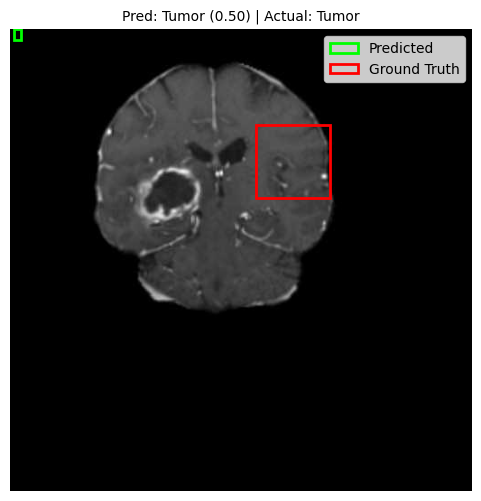

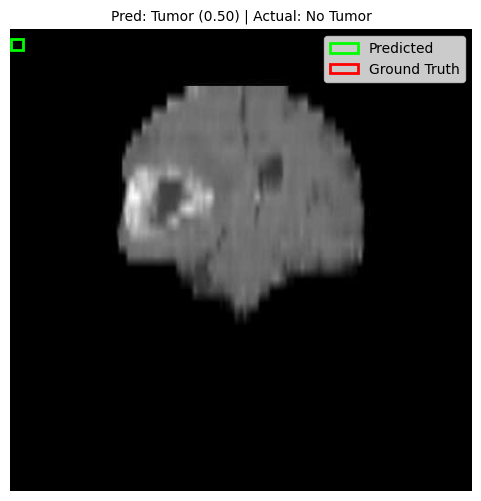

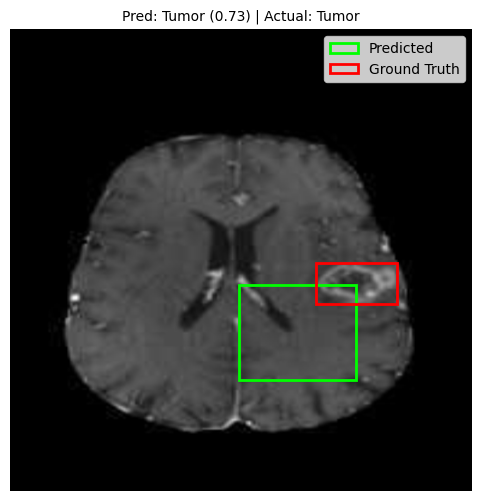

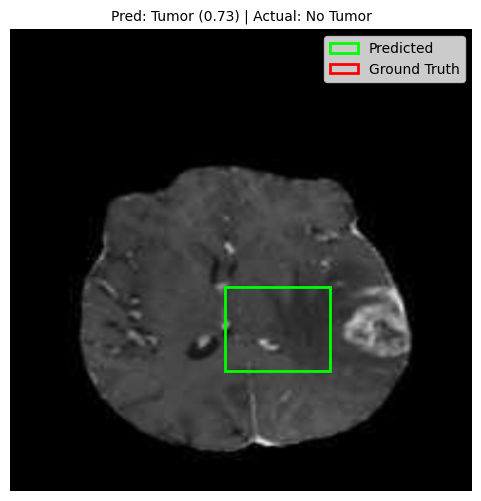

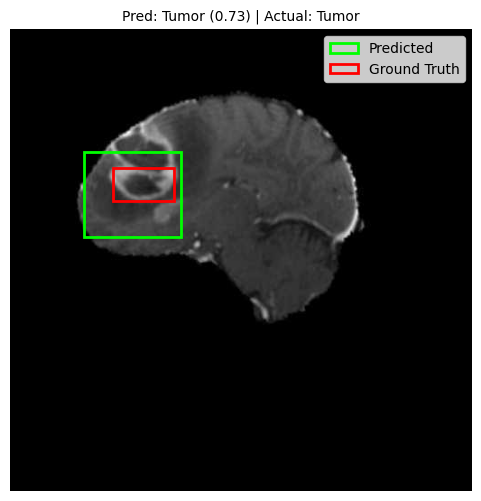

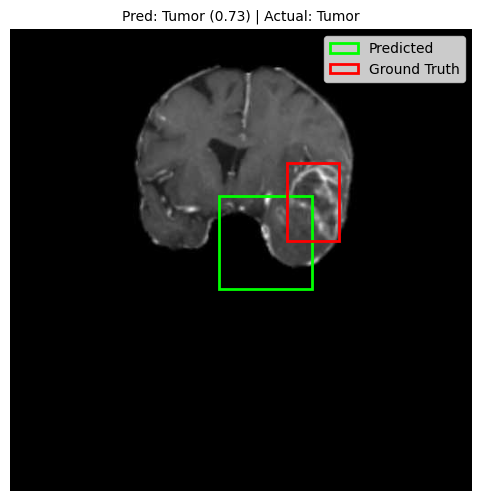

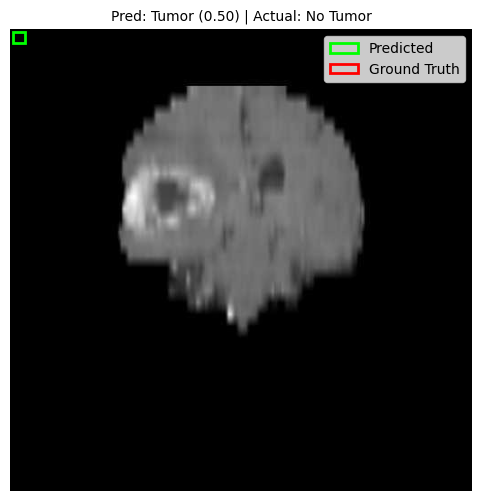

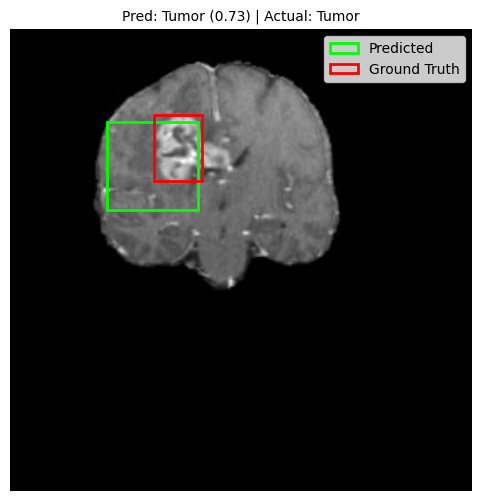

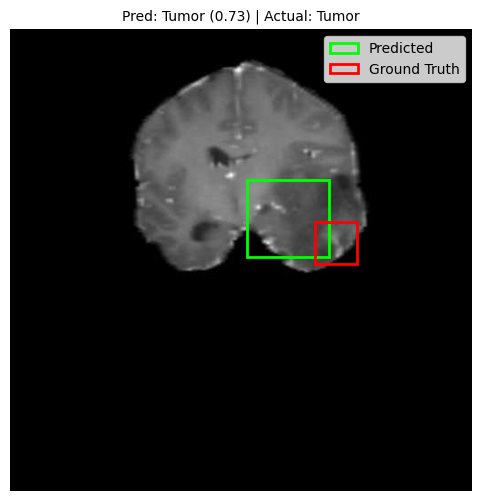

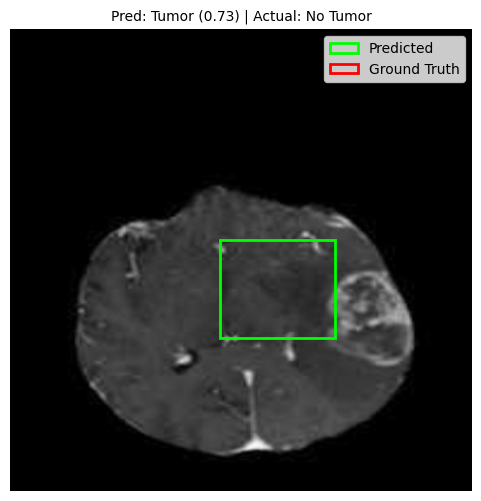

In [ ]:
visualize_predictions(model, test_dataset, num_samples=10)
